# Meningioma vs vestibular schwannoma
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE183655 GSE183655
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi GSE216783

- Loaded - **NO**
- Normalised - **NO**
- Added appropriate 'population' to obs - **NO**
- Identified 'highly_variable' genes - **NO**
- Calibrated constraints for low/high expression - **NO**
- Saved version with limited genes - **NO**

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import os
from pathlib import Path
import seaborn as sb
import matplotlib.pyplot as plt

C:\Anaconda3\envs\IMC\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate list of cases and files

In [2]:
raw_files = 'raw'

In [3]:
files = [x for _,_,x in os.walk("raw")][0]
files_df=pd.Series(files).str.replace('-', '_').str.split('_',expand=True)
files_df.columns=['id','case','file']
files_df['prefix']=files_df['id']+'_'+files_df['case']+'-'

files_df = files_df[~files_df.duplicated('prefix')].reset_index(drop=True)

In [4]:
files_df.head(25)

id   case             file             prefix
0   GSM5567093   MSC1  barcodes.tsv.gz   GSM5567093_MSC1-
1   GSM5567094   MSC2  barcodes.tsv.gz   GSM5567094_MSC2-
2   GSM5567095   MSC3  barcodes.tsv.gz   GSM5567095_MSC3-
3   GSM5567096   MSC4  barcodes.tsv.gz   GSM5567096_MSC4-
4   GSM5567098   MSC5  barcodes.tsv.gz   GSM5567098_MSC5-
5   GSM5567101   MSC6  barcodes.tsv.gz   GSM5567101_MSC6-
6   GSM6692760   SCH1  barcodes.tsv.gz   GSM6692760_SCH1-
7   GSM6692761   SCH2  barcodes.tsv.gz   GSM6692761_SCH2-
8   GSM6692762   SCH3  barcodes.tsv.gz   GSM6692762_SCH3-
9   GSM6692763   SCH4  barcodes.tsv.gz   GSM6692763_SCH4-
10  GSM6692764   SCH5  barcodes.tsv.gz   GSM6692764_SCH5-
11  GSM6692765   SCH6  barcodes.tsv.gz   GSM6692765_SCH6-
12  GSM6692766   SCH7  barcodes.tsv.gz   GSM6692766_SCH7-
13  GSM6692767   SCH8  barcodes.tsv.gz   GSM6692767_SCH8-
14  GSM6692768   SCH9  barcodes.tsv.gz   GSM6692768_SCH9-
15  GSM6692769  SCH13  barcodes.tsv.gz  GSM6692769_SCH13-
16  GSM6692770  SCH14  barcodes.tsv.gz  GSM6692770_SCH14-
17  GSM6692771  SCH18  barcodes.tsv.gz  GSM6692771_SCH18-
18  GSM6692772  SCH20  barcodes.tsv.gz  GSM6692772_SCH20-
19  GSM6692773  SCH21  barcodes.tsv.gz  GSM6692773_SCH21-
20  GSM6692774  SCH22  barcodes.tsv.gz  GSM6692774_SCH22-

### Import and merge all

This next cell can take a while as it needs to load in all the samples (about 30 seconds per sample)

In [ ]:
# Had to rename all the samples in the raw folder to have the same naming system: 
# eg. renamed all men samples from GSM5567093_MSC1_barcodes.tsv to GSM5567093_MSC1-barcodes.tsv by changing the underscore to a hyphen

In [ ]:
# encountered a menory error so closed everything else running on the kernal, restarted python, closed outlook, powerpoint etc...

In [5]:
adatas_list = []

for _, sample in files_df.iterrows():
    print(f'Loading sample {sample.case}')
    adata = sc.read_10x_mtx(Path(raw_files), prefix=sample.prefix)
    adata.obs['run_id']=str(sample.id)
    adata.obs['case']=str(sample.case)
    adatas_list.append(adata.copy())
    
adata = ad.concat(adatas_list)
adata.obs.index = adata.obs.case+"-"+adata.obs.index

Loading sample MSC1
Loading sample MSC2
Loading sample MSC3
Loading sample MSC4
Loading sample MSC5
Loading sample MSC6
Loading sample SCH1
Loading sample SCH2
Loading sample SCH3
Loading sample SCH4
Loading sample SCH5
Loading sample SCH6
Loading sample SCH7
Loading sample SCH8
Loading sample SCH9
Loading sample SCH13
Loading sample SCH14
Loading sample SCH18
Loading sample SCH20
Loading sample SCH21
Loading sample SCH22


MemoryError: Unable to allocate 2.38 GiB for an array with shape (638111250,) and data type int32

In [ ]:
adata.write('adata_afterloadsamples.h5ad')

### QC metrics

In [5]:
sc.pp.calculate_qc_metrics(adata, log1p=False, percent_top=None)

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

C:\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Anaconda3\envs\spatial\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


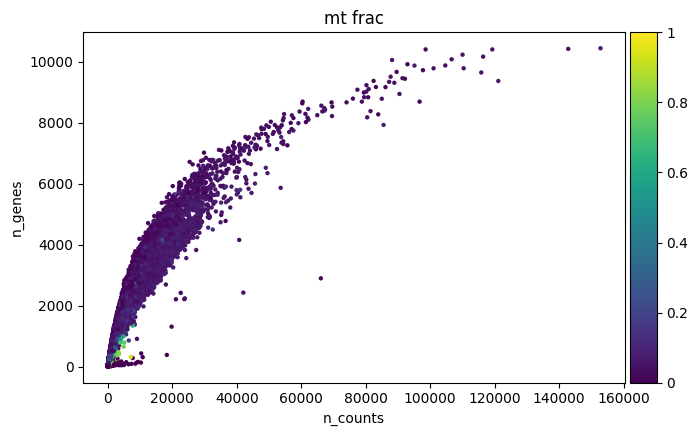

C:\Anaconda3\envs\spatial\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


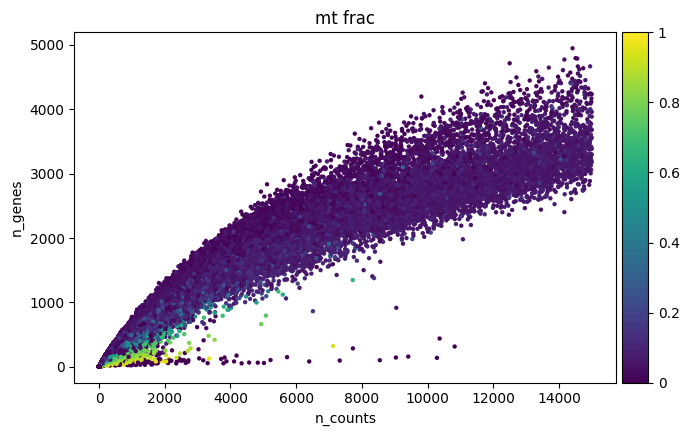

In [6]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<15000], 'n_counts', 'n_genes', 
                   color='mt_frac', size=40)

In [7]:
# Remove any cells with no counts
adata = adata[adata.obs['n_counts'] > 100]

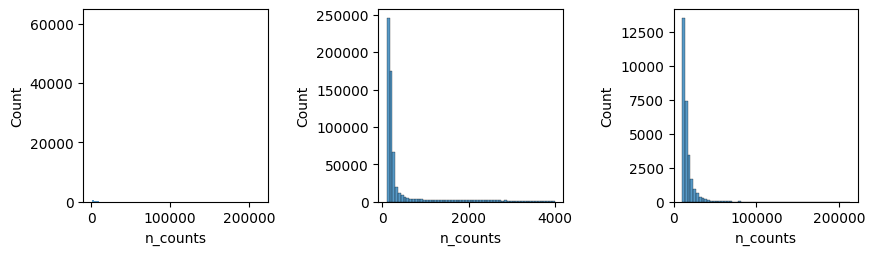

In [8]:
#Thresholding decision: counts
fig_ind=np.arange(131, 134)
fig = plt.figure(figsize=(10,2.5))
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.histplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

<Axes: xlabel='n_counts', ylabel='Count'>

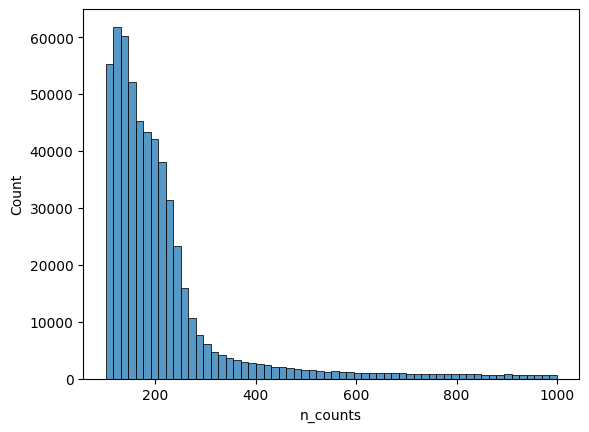

In [9]:
sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<1000], 
                 kde=False, bins=60)

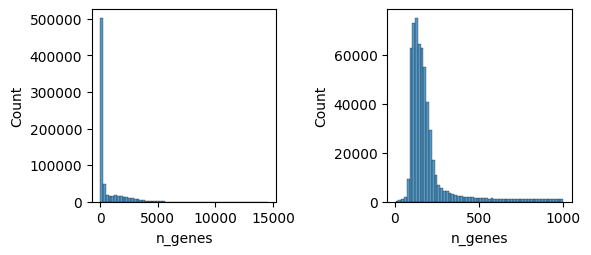

In [10]:
#Thresholding decision: genes
fig_ind=np.arange(131, 133)
fig = plt.figure(figsize=(10,2.5))
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.histplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.histplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

In [11]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 733945


C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\preprocessing\_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


Number of cells after min count filter: 205243
Number of cells after max count filter: 200309
Number of cells after MT filter: 194126


C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Number of cells after gene filter: 161493


In [12]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 36601
Number of genes after cell filter: 29417


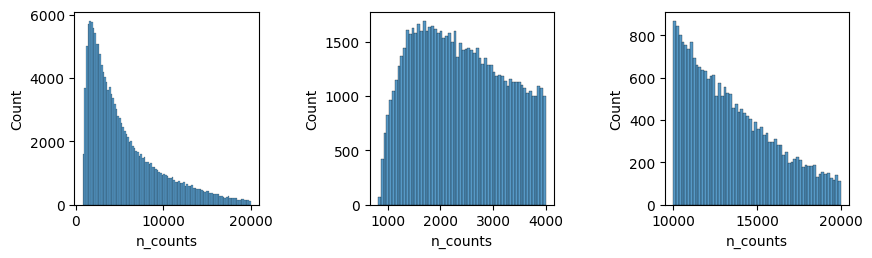

In [13]:
#Thresholding decision: counts
fig_ind=np.arange(131, 134)
fig = plt.figure(figsize=(10,2.5))
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.histplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.histplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

In [14]:
adata.layers['counts'] = adata.X.copy()

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(adata,flavor="cell_ranger",n_top_genes=1500)

C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [18]:
adata.write('VS2_anndata.h5ad')

In [20]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

In [24]:
sc.external.pp.bbknn(adata, batch_key='case')
sc.tl.umap(adata)

C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


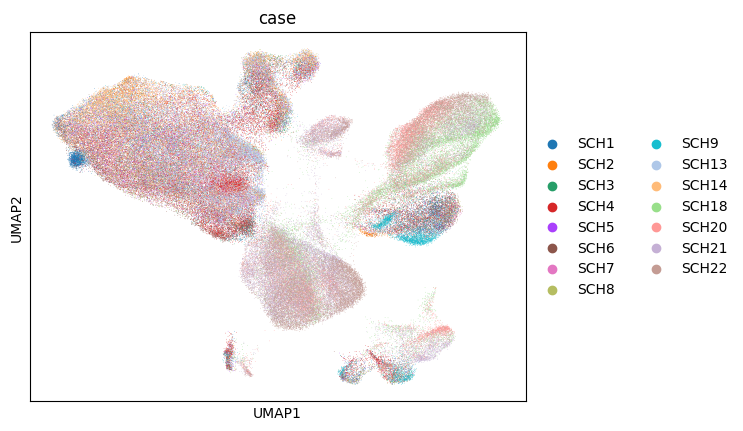

In [25]:
sc.pl.umap(adata, color='case')

In [64]:
sc.tl.leiden(adata, resolution=0.8, key_added='leiden')

C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


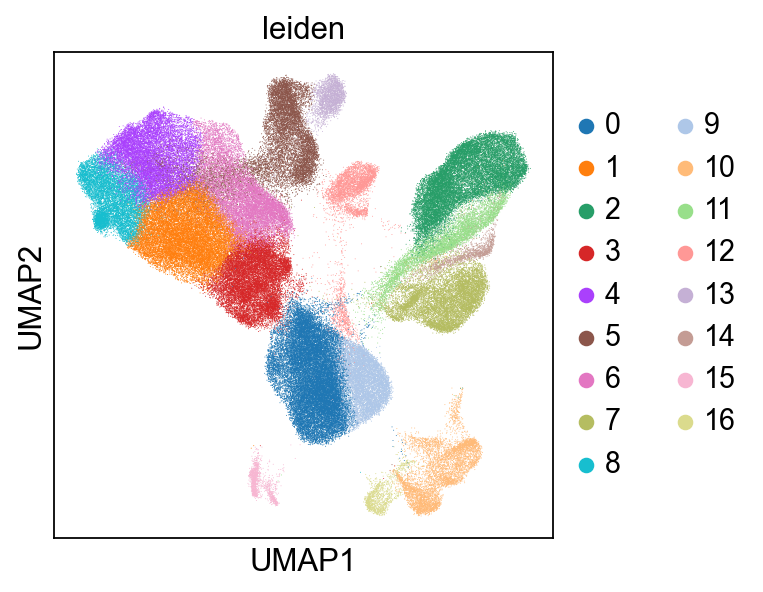

In [65]:
sc.pl.umap(adata, color='leiden')

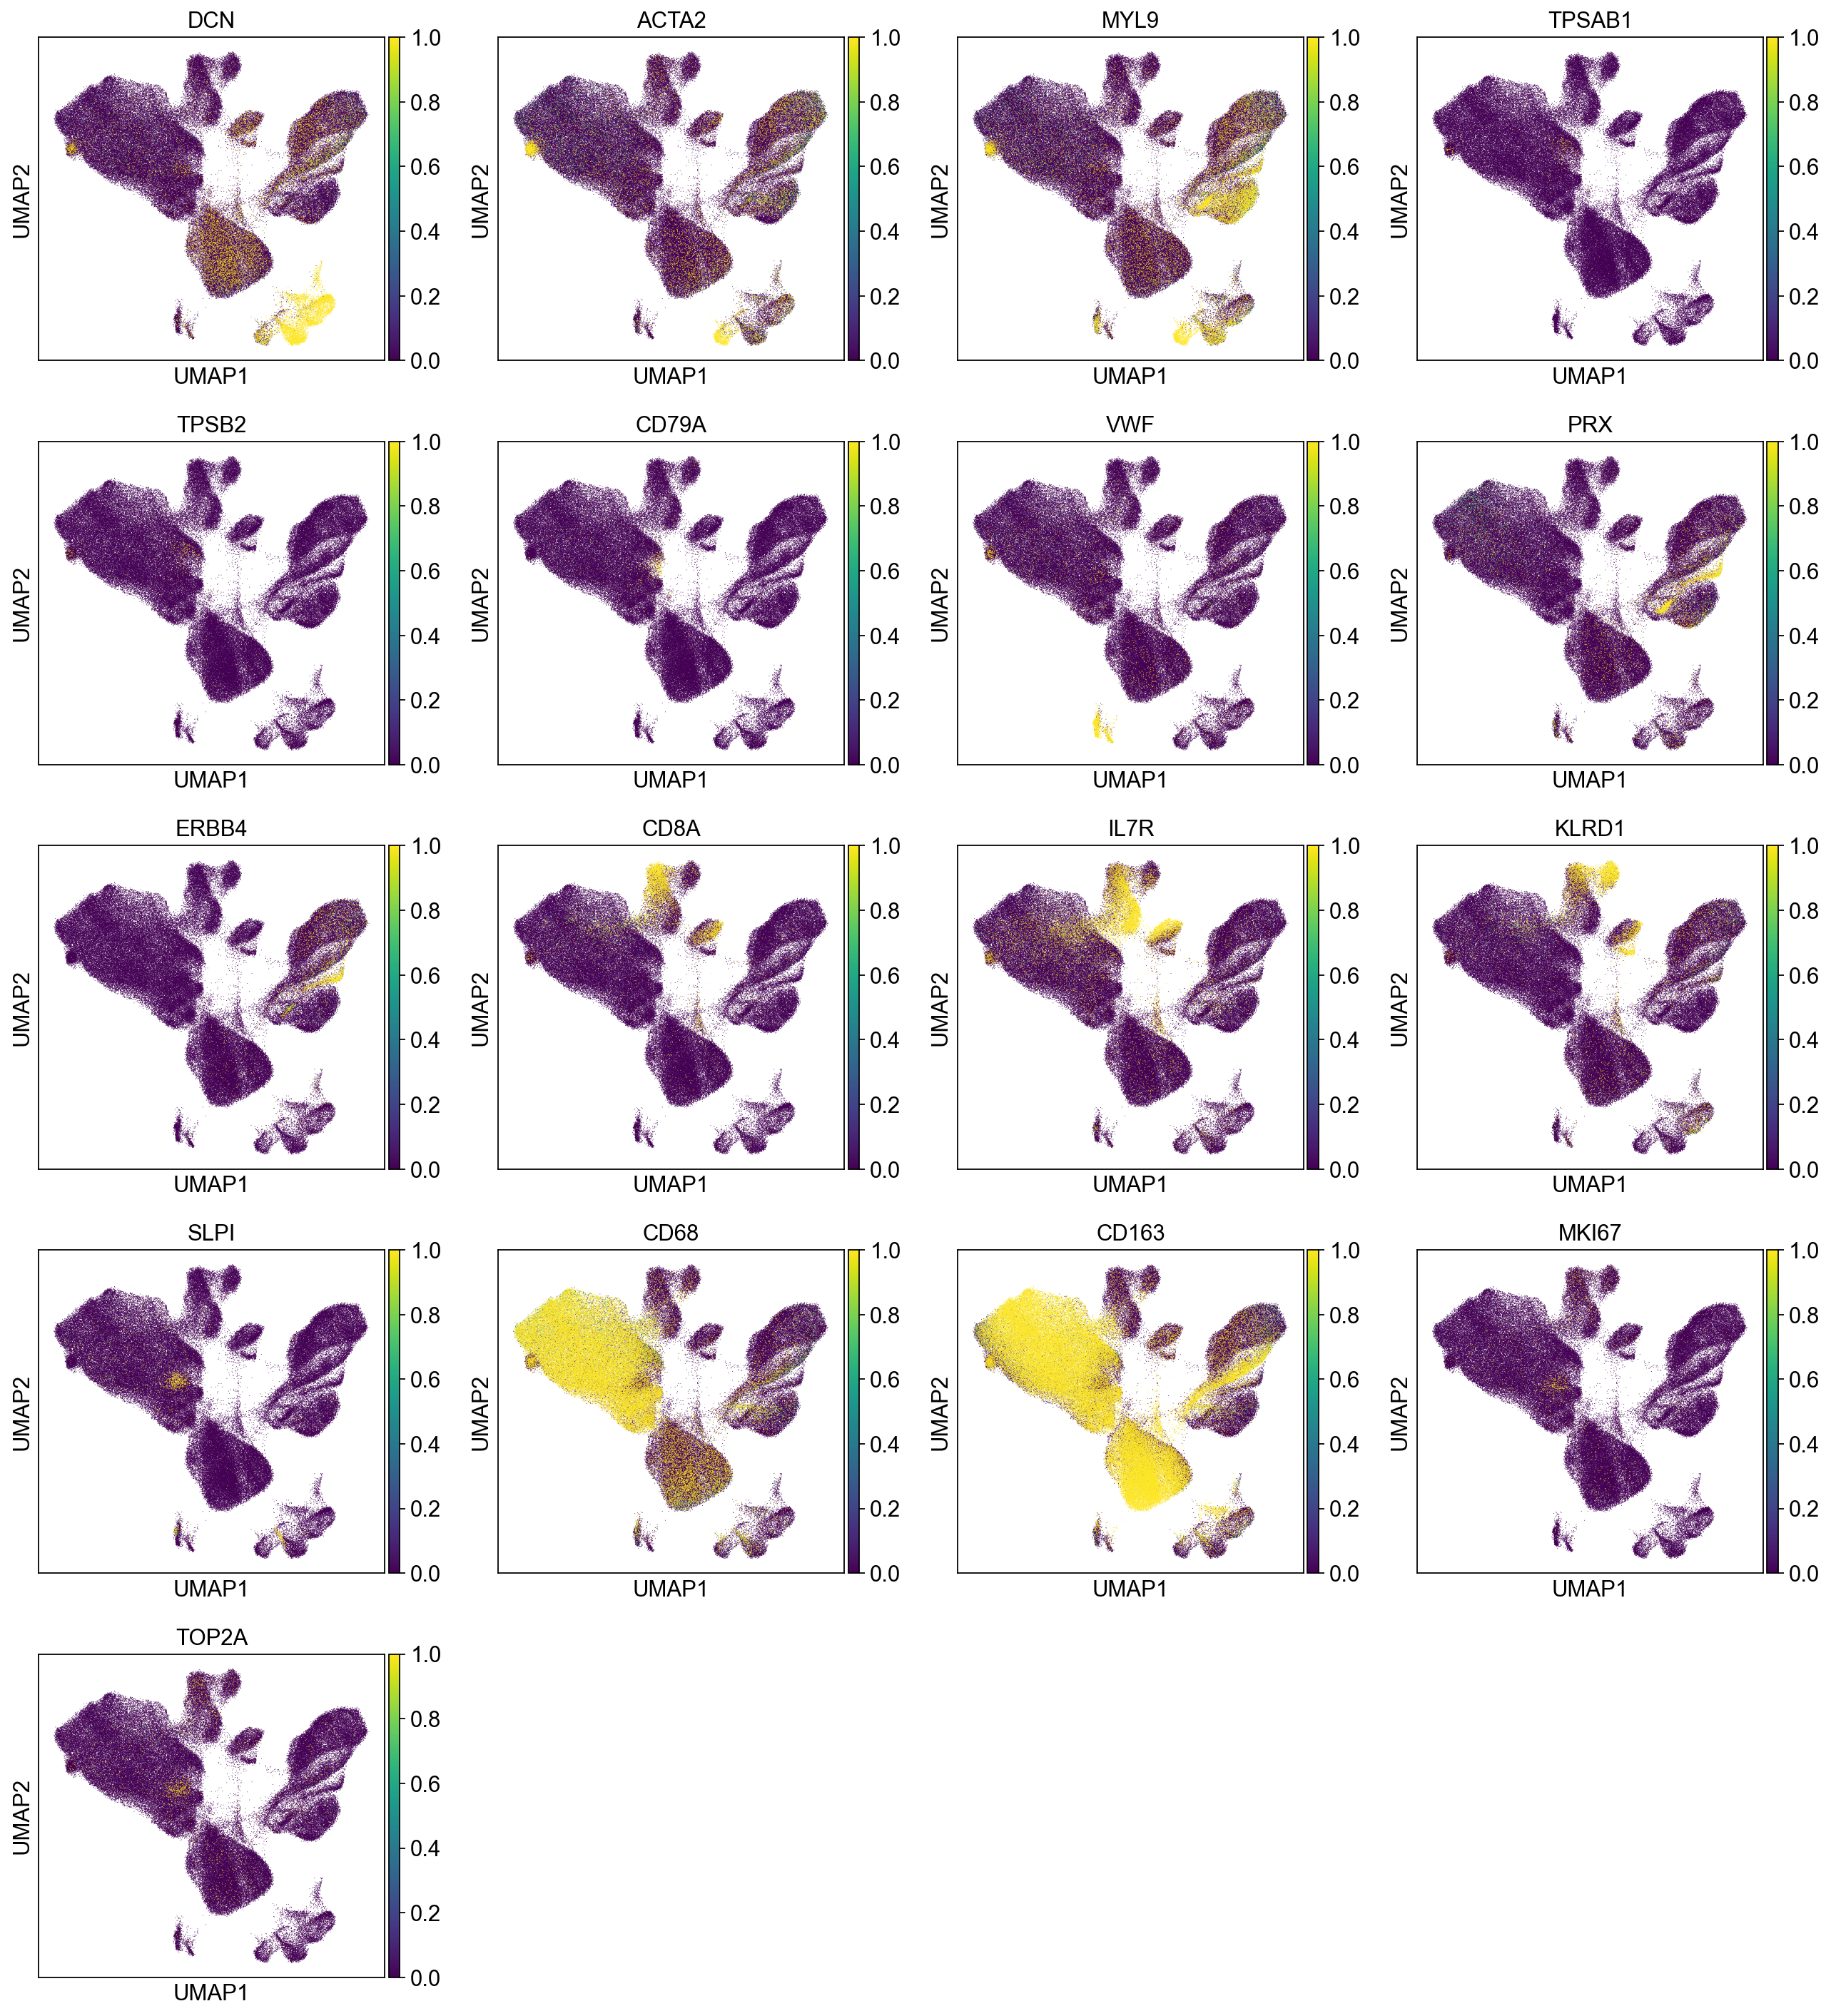

In [71]:
sc.pl.umap(adata, color=['DCN', 'ACTA2','MYL9','TPSAB1','TPSB2','CD79A','VWF', 'PRX', 'ERBB4', 'CD8A', 'IL7R', 'KLRD1', 'SLPI', 'CD68', 'CD163', 'MKI67', 'TOP2A'], vmax=1)

In [67]:
import decoupler as dc

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')

# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

Running ora on mat with 161493 samples and 29417 targets for 151 sources.


100%|█████████████████████████████████████████████████████████████████████████| 161493/161493 [15:17<00:00, 176.00it/s]
C:\Anaconda3\envs\spatial\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 161493 × 151
    obs: 'run_id', 'case', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'case_colors', 'leiden', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\tools\_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


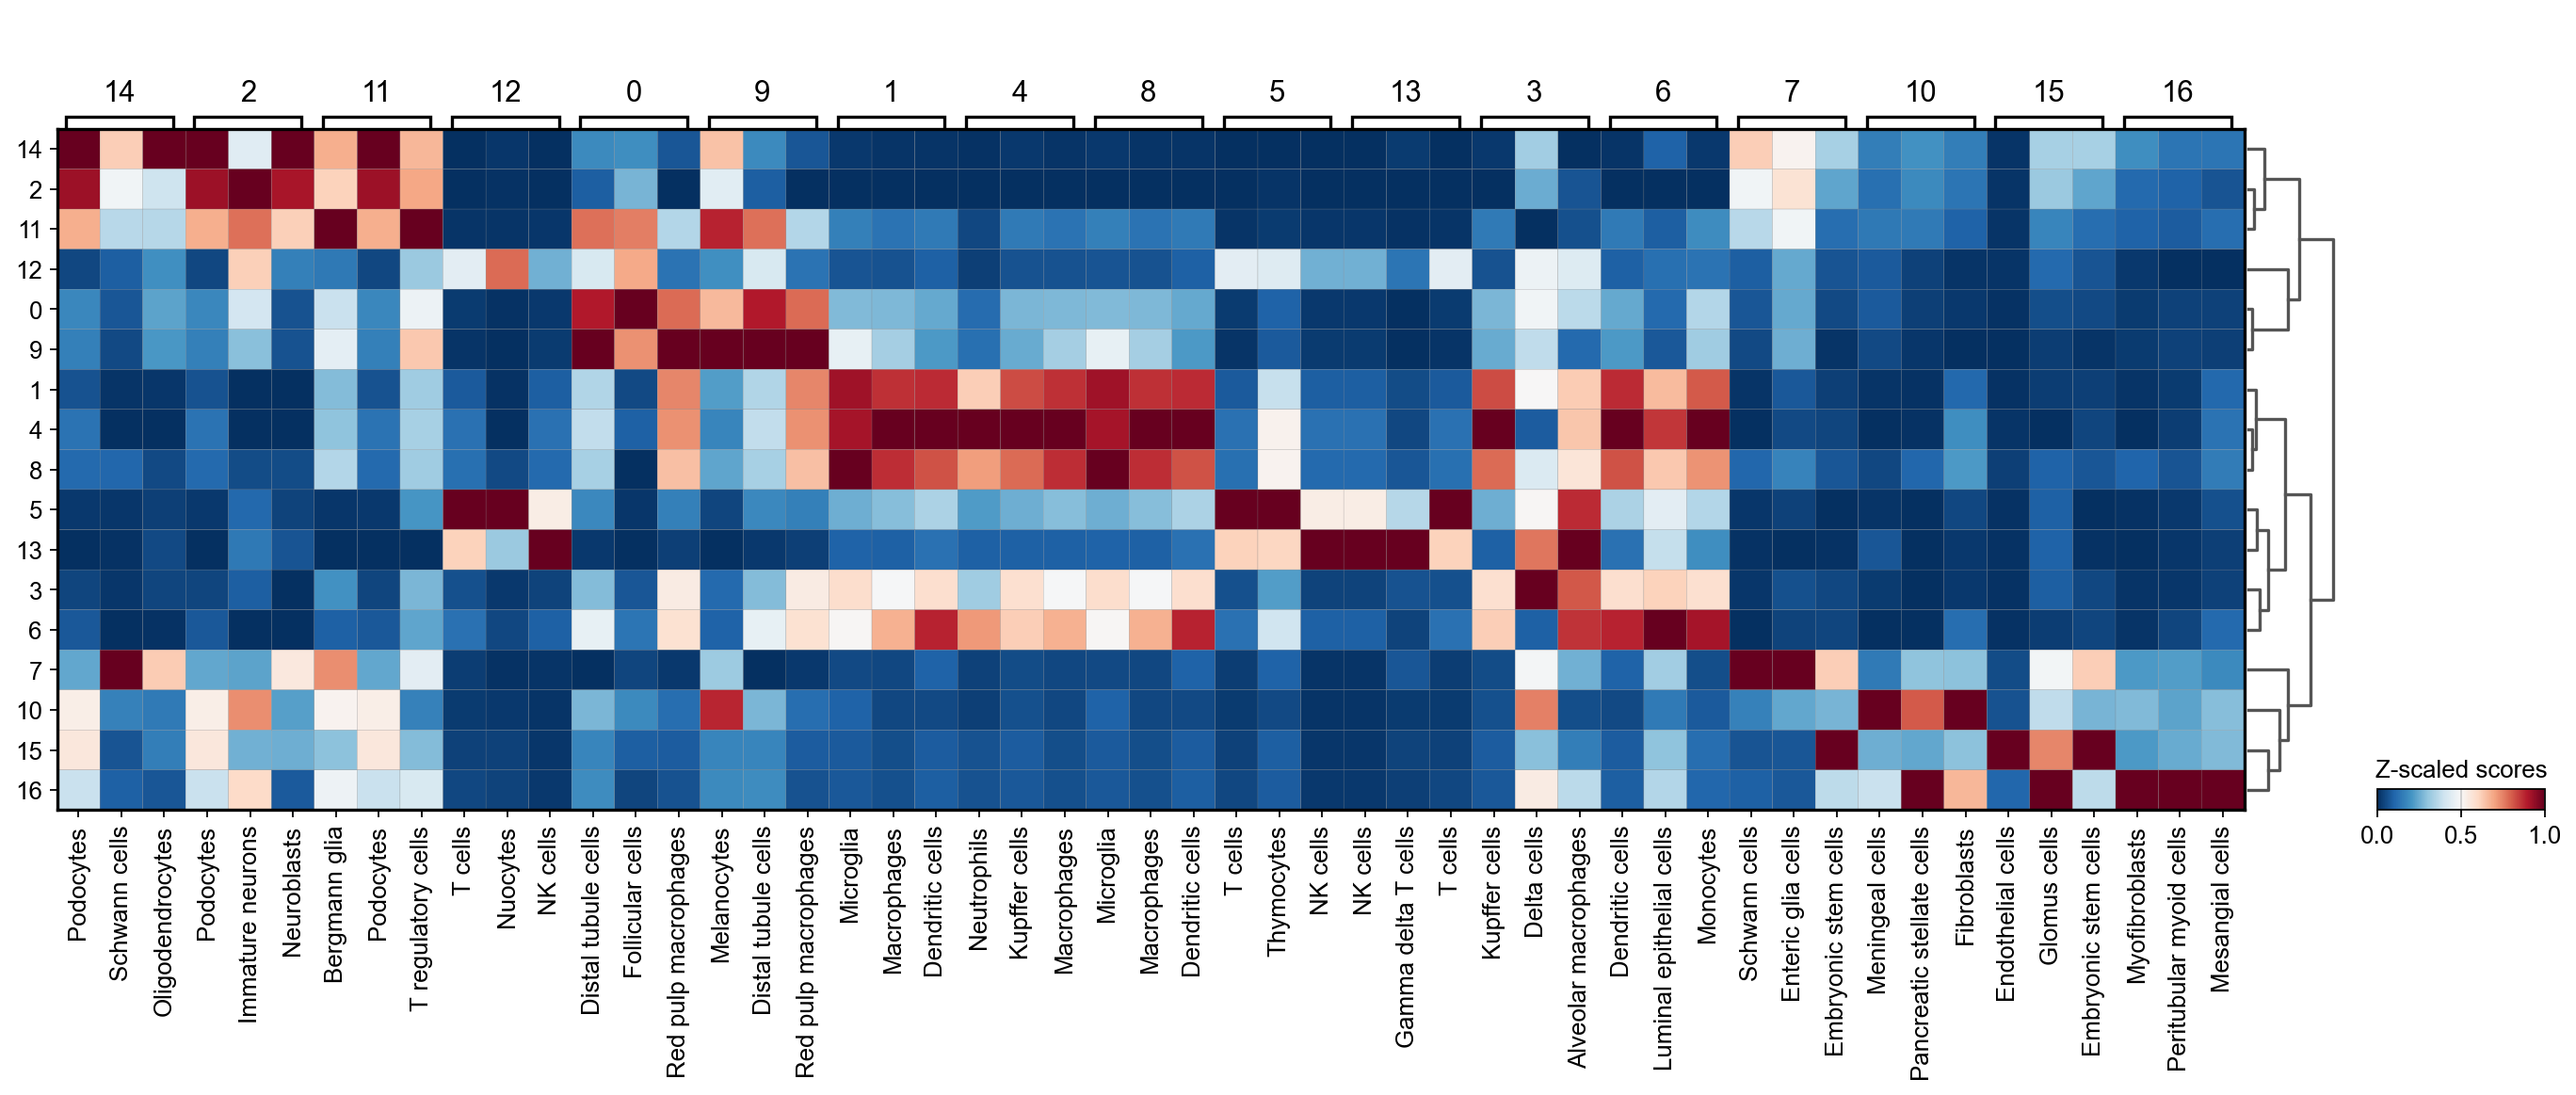

In [68]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')

n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

del acts.uns['dendrogram_leiden']

sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [ ]:
df[df.group=='0'].sort_values('statistic', ascending=False)

In [70]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Distal tubule cells',
 '1': 'Microglia',
 '10': 'Meningeal cells',
 '11': 'Bergmann glia',
 '12': 'T cells',
 '13': 'NK cells',
 '14': 'Podocytes',
 '15': 'Endothelial cells',
 '16': 'Myofibroblasts',
 '2': 'Podocytes',
 '3': 'Kupffer cells',
 '4': 'Neutrophils',
 '5': 'T cells',
 '6': 'Dendritic cells',
 '7': 'Schwann cells',
 '8': 'Microglia',
 '9': 'Melanocytes'}

In [72]:
annotation_dict= {'0': 'Myeloid_1', #YES
 '1': 'Myeloid_2', #YES
 '10': 'Fibroblast',
 '11': 'Schwann_1',
 '12': 'Tcells',
 '13': 'NKcells',
 '14': 'Schwann_2',
 '15': 'Endothelial cells',
 '16': 'Mural',
 '2': 'Schwann_3',
 '3': 'Myeloid_4',
 '4': 'Myeloid_5',
 '5': 'Tcells',
 '6': 'Myeloid_6',
 '7': 'Schwann_4',
 '8': 'Myeloid_7',
 '9': 'Myeloid_8'} #YES

C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


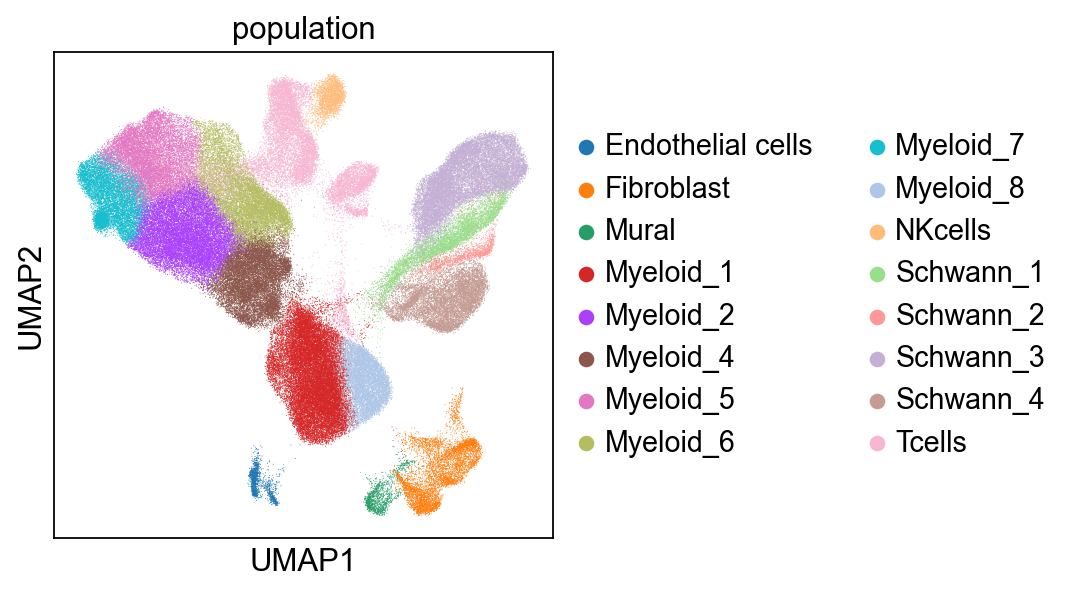

In [74]:
# Add cell type column based on annotation
adata.obs['population'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='population')

In [78]:
adata.write('VS2_anndata.h5ad')

In [79]:
adata = adata[:, adata.var['highly_variable']]

In [80]:
adata.write('VS2_processed_anndata.h5ad')

In [3]:
adata = ad.read_h5ad('VS2_anndata.h5ad', backed='r')

C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Anaconda3\envs\spatial\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


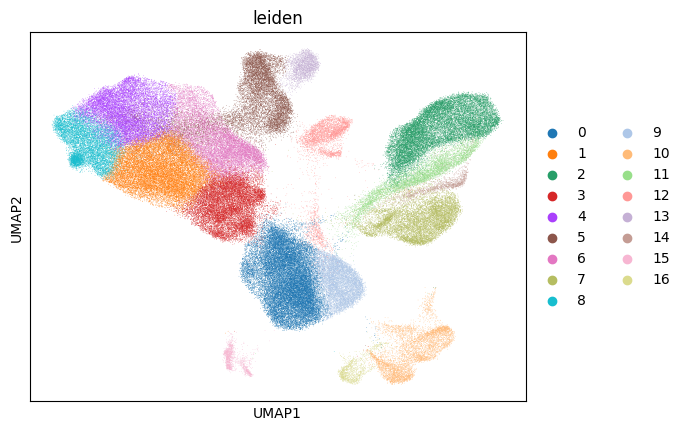

In [5]:
sc.pl.umap(adata, color='leiden')

In [4]:
adata

AnnData object with n_obs × n_vars = 161493 × 29417 backed at 'VS2_anndata.h5ad'
    obs: 'run_id', 'case', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'leiden', 'population'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'case_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'population_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'